In [1]:
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
df = pd.read_csv('Performance_dailytrader.csv', parse_dates=['boughtTimestamp', 'soldTimestamp'])
df2 = pd.read_csv('Performance_APEX.csv', parse_dates=['boughtTimestamp', 'soldTimestamp'])
df = pd.concat([df, df2], axis=0)
df.head()

symbol  _priceFormat  _priceFormatType  _tickSize    buyFillId   sellFillId  \
0   NQU3            -2                 0       0.25  17923520048  17923520007   
1   NQU3            -2                 0       0.25  17923520062  17923520126   
2   NQU3            -2                 0       0.25  17923520193  17923520137   
3   NQU3            -2                 0       0.25  17923520238  17923520210   
4   NQU3            -2                 0       0.25  17923520273  17923520252   

   qty  buyPrice  sellPrice        pnl     boughtTimestamp  \
0    2  15362.50   15341.75  $(830.00) 2023-08-29 11:34:43   
1    2  15371.25   15372.50     $50.00 2023-08-29 11:37:21   
2    2  15373.00   15373.25     $10.00 2023-08-29 11:50:11   
3    2  15370.75   15370.75      $0.00 2023-08-29 11:50:58   
4   48  15375.50   15375.75    $240.00 2023-08-29 11:53:10   

        soldTimestamp     duration  
0 2023-08-29 11:29:26   5min 16sec  
1 2023-08-29 11:48:21  10min 59sec  
2 2023-08-29 11:49:45        25sec  
3 2023-08-29 11:50:32        26sec  
4 2023-08-29 11:52:27        43sec

In [3]:
for column in df.columns:
    unique_value = df[column].unique()
    print(f'unique_value of column {column} are {unique_value}')

unique_value of column symbol are ['NQU3' 'MNQU3']
unique_value of column _priceFormat are [-2]
unique_value of column _priceFormatType are [0]
unique_value of column _tickSize are [0.25]
unique_value of column buyFillId are [17923520048 17923520062 17923520193 17923520238 17923520273 17923520301
 17923520316 17923520347 17923520358 17923520378 17923520407 17923520427
 17923520438 17923520458 17923520516 17923520543 17923520551 17923520574
 17923520585 17923520676 17923520706 17923520714 17923520722 17923520752
 17923520760 17923520783 17923520810 17923520818 17923520865 17923520896
 17923520904 17923520912 17923520996 17923521004 17923521012 17923521077
 17923521085 17923521093 17923521116 17923521155 17923521185 17923521193
 17923521231 17923521281 17923521312 17923521348 17923521422 17923521460
 17923521494 17923521502 17923521516 17923521606 17923521684 17923521692
 17923521755 17923521798 17923522003 17923522075 17923522095 17923522224
 17923522263 17923522309 17923522353 17923522

In [4]:
df.drop(columns=['symbol','_priceFormat', '_priceFormatType', '_tickSize','buyFillId', 'sellFillId'], inplace=True)
df.head()

qty  buyPrice  sellPrice        pnl     boughtTimestamp  \
0    2  15362.50   15341.75  $(830.00) 2023-08-29 11:34:43   
1    2  15371.25   15372.50     $50.00 2023-08-29 11:37:21   
2    2  15373.00   15373.25     $10.00 2023-08-29 11:50:11   
3    2  15370.75   15370.75      $0.00 2023-08-29 11:50:58   
4   48  15375.50   15375.75    $240.00 2023-08-29 11:53:10   

        soldTimestamp     duration  
0 2023-08-29 11:29:26   5min 16sec  
1 2023-08-29 11:48:21  10min 59sec  
2 2023-08-29 11:49:45        25sec  
3 2023-08-29 11:50:32        26sec  
4 2023-08-29 11:52:27        43sec

In [5]:
df.columns

Index(['qty', 'buyPrice', 'sellPrice', 'pnl', 'boughtTimestamp',
       'soldTimestamp', 'duration'],
      dtype='object')

In [6]:
pattern = r'\((-?\d+\.\d+)\)'
# match = re.search(pattern, input_string)

In [7]:
def replace_and_convert(match):
    number_in_parentheses = float(match.group(1))
    if number_in_parentheses > 0:
        number_in_parentheses = -number_in_parentheses
    return str(number_in_parentheses)

In [8]:
def convert_to_timedelta(duration_str):
    parts = duration_str.split()
    total_seconds = 0
    
    for part in parts:
        if 'min' in part:
            total_seconds += int(part.replace('min', '')) * 60
        elif 'sec' in part:
            total_seconds += int(part.replace('sec', ''))
            
    return pd.Timedelta(seconds=total_seconds)
            

In [9]:
df['pnl'] = df['pnl'].apply(lambda x: x.replace('$', '').replace(',', ''))
df['pnl'] = df['pnl'].apply(lambda x: re.sub(pattern, replace_and_convert, x))
df['pnl'] = df['pnl'].apply(lambda x: float(x))
df['qty'] = df['qty'].apply(lambda x: int(x))
df['duration'] = df['duration'].apply(convert_to_timedelta)

In [10]:
df.head()

qty  buyPrice  sellPrice    pnl     boughtTimestamp       soldTimestamp  \
0    2  15362.50   15341.75 -830.0 2023-08-29 11:34:43 2023-08-29 11:29:26   
1    2  15371.25   15372.50   50.0 2023-08-29 11:37:21 2023-08-29 11:48:21   
2    2  15373.00   15373.25   10.0 2023-08-29 11:50:11 2023-08-29 11:49:45   
3    2  15370.75   15370.75    0.0 2023-08-29 11:50:58 2023-08-29 11:50:32   
4   48  15375.50   15375.75  240.0 2023-08-29 11:53:10 2023-08-29 11:52:27   

         duration  
0 0 days 00:05:16  
1 0 days 00:10:59  
2 0 days 00:00:25  
3 0 days 00:00:26  
4 0 days 00:00:43

In [11]:
# df_sub = df[(df['boughtTimestamp'].dt.hour <= 12) & (df['qty'] <= 10)]
# df_sub = df[(df['pnl'] > 0) & (df['qty'] <= 2) & (df['boughtTimestamp'].dt.hour <= 12)]
df.groupby(df['boughtTimestamp'].dt.date)[['pnl', 'qty', 'duration']].describe()

pnl                                                        \
                 count        mean          std      min   25%   50%     75%   
boughtTimestamp                                                                
2023-08-29        50.0 -399.700000  2333.122505 -11520.0  10.0  37.5  240.00   
2023-09-01         5.0   76.000000   165.015151    -20.0   0.0  10.0   20.00   
2023-09-05        22.0  120.681818   525.004071   -890.0  -7.5  40.0  230.00   
2023-09-06         1.0    3.000000          NaN      3.0   3.0   3.0    3.00   
2023-09-07       110.0  -71.500000   609.102796  -3050.0   0.0  25.0   86.25   
2023-09-08        53.0    3.566038   101.394414   -280.0 -10.0  10.0   40.00   

                           qty             ...             duration  \
                    max  count       mean  ...   75%   max    count   
boughtTimestamp                            ...                        
2023-08-29       2070.0   50.0  15.320000  ...  24.0  48.0       50   
2023-09-01        370.0    5.0   1.600000  ...   2.0   2.0        5   
2023-09-05       2160.0   22.0   4.636364  ...   3.5  36.0       22   
2023-09-06          3.0    1.0   2.000000  ...   2.0   2.0        1   
2023-09-07        900.0  110.0   5.418182  ...  10.0  10.0      110   
2023-09-08        410.0   53.0   1.547170  ...   2.0   2.0       53   

                                                                       \
                                      mean                        std   
boughtTimestamp                                                         
2023-08-29          0 days 00:01:43.660000  0 days 00:02:46.426990795   
2023-09-01          0 days 00:00:45.200000  0 days 00:00:28.700174215   
2023-09-05       0 days 00:03:06.454545454  0 days 00:04:42.108848846   
2023-09-06                 0 days 00:00:02                        NaT   
2023-09-07       0 days 00:01:22.390909090  0 days 00:02:37.456334151   
2023-09-08       0 days 00:00:22.169811320  0 days 00:00:19.041185977   

                                                          \
                             min                     25%   
boughtTimestamp                                            
2023-08-29       0 days 00:00:02         0 days 00:00:21   
2023-09-01       0 days 00:00:21         0 days 00:00:22   
2023-09-05       0 days 00:00:03         0 days 00:00:34   
2023-09-06       0 days 00:00:02         0 days 00:00:02   
2023-09-07       0 days 00:00:01  0 days 00:00:15.250000   
2023-09-08       0 days 00:00:01         0 days 00:00:08   

                                                                 \
                                    50%                     75%   
boughtTimestamp                                                   
2023-08-29       0 days 00:00:36.500000  0 days 00:01:20.750000   
2023-09-01              0 days 00:00:31         0 days 00:01:10   
2023-09-05              0 days 00:01:59         0 days 00:03:07   
2023-09-06              0 days 00:00:02         0 days 00:00:02   
2023-09-07              0 days 00:00:35         0 days 00:01:13   
2023-09-08              0 days 00:00:20         0 days 00:00:28   

                                  
                             max  
boughtTimestamp                   
2023-08-29       0 days 00:10:59  
2023-09-01       0 days 00:01:22  
2023-09-05       0 days 00:21:12  
2023-09-06       0 days 00:00:02  
2023-09-07       0 days 00:22:47  
2023-09-08       0 days 00:01:25  

[6 rows x 24 columns]

In [12]:
df.groupby(df['boughtTimestamp'].dt.date)[['pnl', 'qty', 'duration']].sum()

pnl  qty        duration
boughtTimestamp                              
2023-08-29      -19985.0  766 0 days 01:26:23
2023-09-01         380.0    8 0 days 00:03:46
2023-09-05        2655.0  102 0 days 01:08:22
2023-09-06           3.0    2 0 days 00:00:02
2023-09-07       -7865.0  596 0 days 02:31:03
2023-09-08         189.0   82 0 days 00:19:35

In [13]:
df_sub = df[(df['boughtTimestamp'].dt.hour <= 12) & (df['qty'] <= 10)]
# df_sub = df[(df['pnl'] > 0) & (df['qty'] <= 2) & (df['boughtTimestamp'].dt.hour <= 12)]
df_sub.groupby(df_sub['boughtTimestamp'].dt.date)[['pnl', 'qty', 'duration']].describe()

pnl                                                        \
                count        mean         std     min     25%    50%    75%   
boughtTimestamp                                                               
2023-08-29       19.0 -108.157895  416.724031 -1620.0   10.00   15.0   30.0   
2023-09-01        1.0  370.000000         NaN   370.0  370.00  370.0  370.0   
2023-09-05       14.0   -3.571429  303.482534  -890.0  -22.50   40.0  150.0   
2023-09-07       38.0   92.763158  346.401769  -920.0   11.25   35.0  127.5   
2023-09-08       17.0   50.764706  115.379553  -120.0    0.00   10.0   50.0   

                         qty            ...             duration  \
                   max count      mean  ...   75%   max    count   
boughtTimestamp                         ...                        
2023-08-29       120.0  19.0  2.368421  ...   3.0   9.0       19   
2023-09-01       370.0   1.0  2.000000  ...   2.0   2.0        1   
2023-09-05       380.0  14.0  2.285714  ...   2.0   6.0       14   
2023-09-07       900.0  38.0  5.421053  ...  10.0  10.0       38   
2023-09-08       410.0  17.0  1.647059  ...   2.0   2.0       17   

                                                                       \
                                      mean                        std   
boughtTimestamp                                                         
2023-08-29       0 days 00:02:19.052631578  0 days 00:03:17.233497742   
2023-09-01                 0 days 00:01:10                        NaT   
2023-09-05       0 days 00:04:08.428571428  0 days 00:05:39.020696959   
2023-09-07       0 days 00:00:34.842105263  0 days 00:00:43.316887859   
2023-09-08       0 days 00:00:18.705882352  0 days 00:00:21.250778532   

                                                                           \
                             min                     25%              50%   
boughtTimestamp                                                             
2023-08-29       0 days 00:00:19  0 days 00:00:21.500000  0 days 00:00:51   
2023-09-01       0 days 00:01:10         0 days 00:01:10  0 days 00:01:10   
2023-09-05       0 days 00:00:03  0 days 00:00:56.250000  0 days 00:02:24   
2023-09-07       0 days 00:00:02  0 days 00:00:10.500000  0 days 00:00:22   
2023-09-08       0 days 00:00:01         0 days 00:00:05  0 days 00:00:10   

                                                   
                             75%              max  
boughtTimestamp                                    
2023-08-29       0 days 00:01:44  0 days 00:10:59  
2023-09-01       0 days 00:01:10  0 days 00:01:10  
2023-09-05       0 days 00:04:10  0 days 00:21:12  
2023-09-07       0 days 00:00:35  0 days 00:03:36  
2023-09-08       0 days 00:00:23  0 days 00:01:25  

[5 rows x 24 columns]

In [14]:
df_sub.groupby(df_sub['boughtTimestamp'].dt.date)[['pnl', 'qty', 'duration']].sum()


pnl  qty        duration
boughtTimestamp                             
2023-08-29      -2055.0   45 0 days 00:44:02
2023-09-01        370.0    2 0 days 00:01:10
2023-09-05        -50.0   32 0 days 00:57:58
2023-09-07       3525.0  206 0 days 00:22:04
2023-09-08        863.0   28 0 days 00:05:18

In [15]:
df_sub = df[(df['boughtTimestamp'].dt.hour <= 12) & (df['qty'] <= 2)]
# df_sub = df[(df['pnl'] > 0) & (df['qty'] <= 2) & (df['boughtTimestamp'].dt.hour <= 12)]
df_sub.groupby(df_sub['boughtTimestamp'].dt.date)[['pnl', 'qty', 'duration']].describe()

pnl                                                      \
                count        mean         std    min    25%    50%    75%   
boughtTimestamp                                                             
2023-08-29       13.0  -56.538462  234.221980 -830.0   10.0   10.0   15.0   
2023-09-01        1.0  370.000000         NaN  370.0  370.0  370.0  370.0   
2023-09-05       12.0  -44.166667  310.262597 -890.0  -47.5   25.0   60.0   
2023-09-07       17.0  -20.000000  256.143270 -920.0   10.0   20.0   30.0   
2023-09-08       17.0   50.764706  115.379553 -120.0    0.0   10.0   50.0   

                         qty            ...           duration  \
                   max count      mean  ...  75%  max    count   
boughtTimestamp                         ...                      
2023-08-29        50.0  13.0  1.384615  ...  2.0  2.0       13   
2023-09-01       370.0   1.0  2.000000  ...  2.0  2.0        1   
2023-09-05       380.0  12.0  1.833333  ...  2.0  2.0       12   
2023-09-07       340.0  17.0  1.588235  ...  2.0  2.0       17   
2023-09-08       410.0  17.0  1.647059  ...  2.0  2.0       17   

                                                                       \
                                      mean                        std   
boughtTimestamp                                                         
2023-08-29       0 days 00:02:23.615384615  0 days 00:03:30.788811555   
2023-09-01                 0 days 00:01:10                        NaT   
2023-09-05       0 days 00:04:38.083333333  0 days 00:05:58.173766445   
2023-09-07       0 days 00:00:36.529411764  0 days 00:00:31.630913769   
2023-09-08       0 days 00:00:18.705882352  0 days 00:00:21.250778532   

                                                          \
                             min                     25%   
boughtTimestamp                                            
2023-08-29       0 days 00:00:21         0 days 00:00:22   
2023-09-01       0 days 00:01:10         0 days 00:01:10   
2023-09-05       0 days 00:00:08  0 days 00:01:28.750000   
2023-09-07       0 days 00:00:08         0 days 00:00:13   
2023-09-08       0 days 00:00:01         0 days 00:00:05   

                                                                 \
                                    50%                     75%   
boughtTimestamp                                                   
2023-08-29              0 days 00:00:51         0 days 00:01:44   
2023-09-01              0 days 00:01:10         0 days 00:01:10   
2023-09-05       0 days 00:02:36.500000  0 days 00:04:22.250000   
2023-09-07              0 days 00:00:23         0 days 00:00:48   
2023-09-08              0 days 00:00:10         0 days 00:00:23   

                                  
                             max  
boughtTimestamp                   
2023-08-29       0 days 00:10:59  
2023-09-01       0 days 00:01:10  
2023-09-05       0 days 00:21:12  
2023-09-07       0 days 00:01:53  
2023-09-08       0 days 00:01:25  

[5 rows x 24 columns]

In [16]:
df_sub.groupby(df_sub['boughtTimestamp'].dt.date)[['pnl', 'qty', 'duration']].sum()


pnl  qty        duration
boughtTimestamp                            
2023-08-29      -735.0   18 0 days 00:31:07
2023-09-01       370.0    2 0 days 00:01:10
2023-09-05      -530.0   22 0 days 00:55:37
2023-09-07      -340.0   27 0 days 00:10:21
2023-09-08       863.0   28 0 days 00:05:18

In [17]:
df_sub['pnl'].sum()

-372.0

In [18]:
df_sub.describe()

qty      buyPrice     sellPrice         pnl  \
count  60.000000     60.000000     60.000000   60.000000   
mean    1.616667  15361.550000  15361.608333   -6.200000   
min     1.000000  15231.000000  15231.750000 -920.000000   
25%     1.000000  15271.750000  15268.937500    0.000000   
50%     2.000000  15338.625000  15338.750000   15.000000   
75%     2.000000  15372.625000  15373.062500   40.000000   
max     2.000000  15558.000000  15558.250000  410.000000   
std     0.490301    102.675973    102.525424  233.982746   

                     boughtTimestamp                  soldTimestamp  \
count                             60                             60   
mean   2023-09-05 08:02:06.266666752  2023-09-05 08:00:56.950000128   
min              2023-08-29 11:34:43            2023-08-29 11:29:26   
25%              2023-09-05 11:38:55  2023-09-05 11:35:37.249999872   
50%       2023-09-07 10:42:28.500000            2023-09-07 10:42:49   
75%    2023-09-08 12:22:37.750000128  2023-09-08 12:22:28.249999872   
max              2023-09-08 12:50:25            2023-09-08 12:50:01   
std                              NaN                            NaN   

                        duration  
count                         60  
mean      0 days 00:01:43.550000  
min              0 days 00:00:01  
25%       0 days 00:00:13.750000  
50%              0 days 00:00:26  
75%              0 days 00:01:27  
max              0 days 00:21:12  
std    0 days 00:03:28.052342257

In [19]:
df_sub.groupby(df_sub.boughtTimestamp.dt.quarter)['pnl'].describe()

count  mean         std    min  25%   50%   75%    max
boughtTimestamp                                                        
3                 60.0  -6.2  233.982746 -920.0  0.0  15.0  40.0  410.0

C:\Users\Farhad\AppData\Local\Temp\ipykernel_31948\3139245389.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['timestamp_string'] = df_sub['boughtTimestamp'].dt.strftime('%y-%m-%d %H:%M:%S')
C:\Users\Farhad\AppData\Local\Temp\ipykernel_31948\3139245389.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop_duplicates(subset='timestamp_string', keep = 'first', inplace=True)
C:\Users\Farhad\AppData\Local\Temp\ipykernel_31948\3139245389.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .l

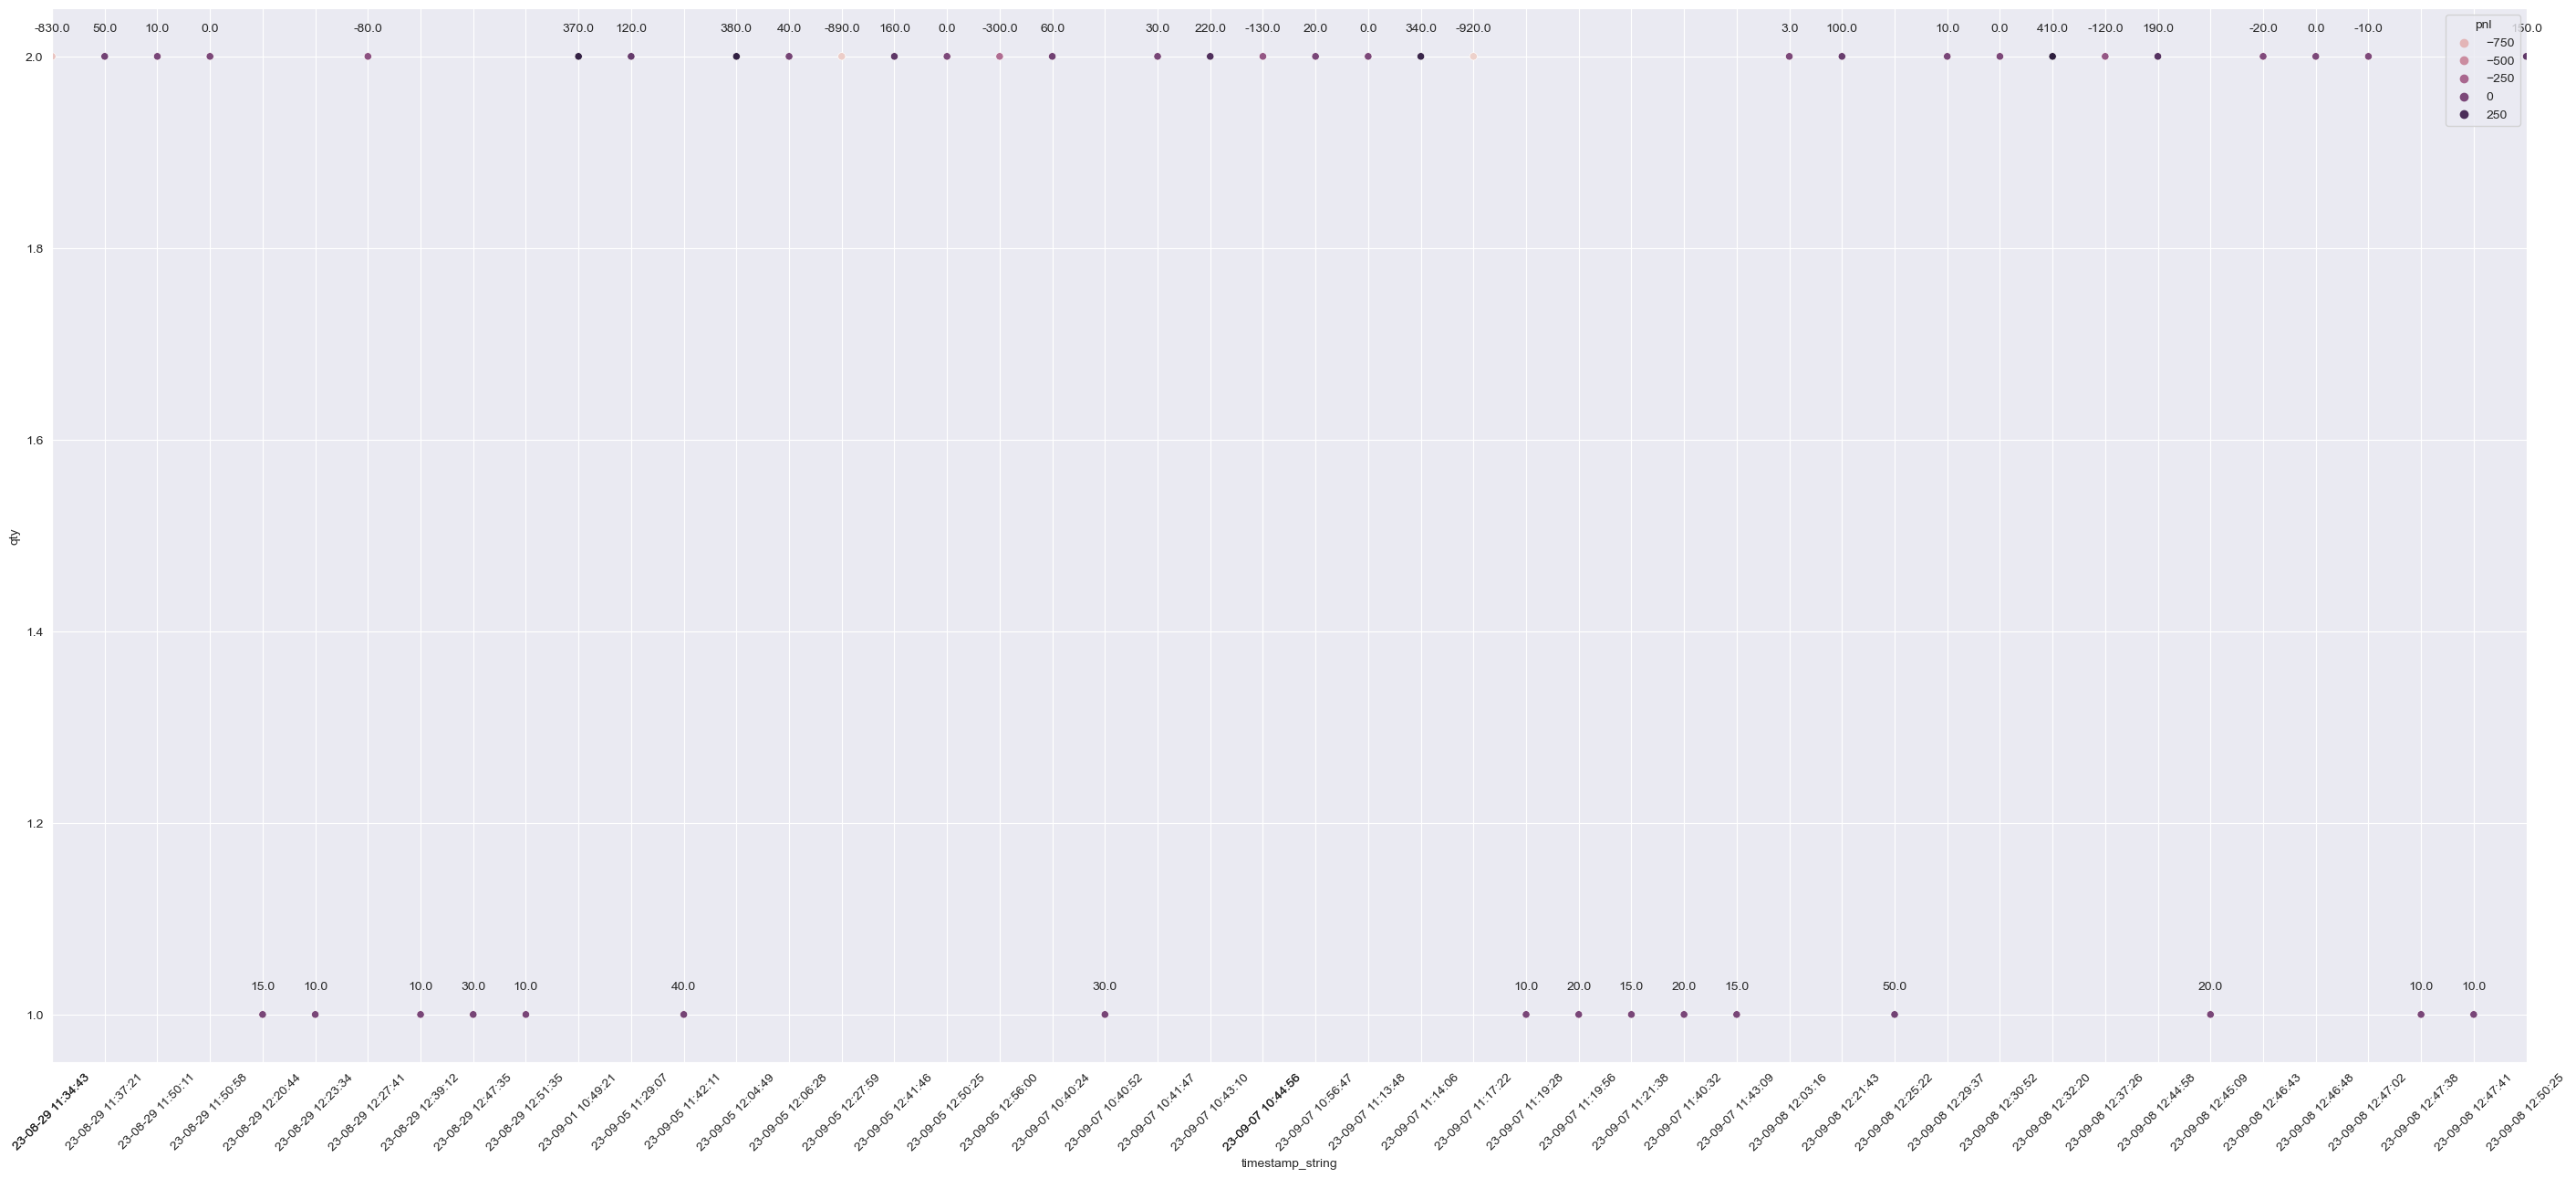

In [20]:
plt.figure(figsize=(35, 15))
# Create a scatter plot using Seaborn
df_sub['timestamp_string'] = df_sub['boughtTimestamp'].dt.strftime('%y-%m-%d %H:%M:%S')

df_sub.groupby('timestamp_string')[['pnl', 'pnl']].sum().reset_index()
# df_sub.groupby('soldTimestamp')[['pnl', 'pnl']].sum().reset_index()
df_sub.drop_duplicates(subset='timestamp_string', keep = 'first', inplace=True)
# df_sub.drop_duplicates(subset='soldTimestamp', keep = 'first')

df_sub['timestamp_string'] = df_sub['boughtTimestamp'].dt.strftime('%y-%m-%d %H:%M:%S')

sns.scatterplot(data=df_sub, x='timestamp_string', y='qty', hue='pnl')

# Annotate data points with labels from the 'label_column' column and adjust font properties
for index, row in df_sub.iterrows():

    plt.annotate(str(row['pnl']), (row['timestamp_string'], row['qty']), textcoords="offset points", xytext=(0, 20), ha='center')

plt.xticks(rotation=45)

num_xticks = 50

latest_timestamp = df_sub['boughtTimestamp'].max().strftime('%y-%m-%d %H:%M:%S')  # Apply strftime to datetime
plt.xlim(0, latest_timestamp)

# Set x-tick positions evenly distributed across the x-axis
x_positions = np.linspace(0, len(df_sub) - 1, num_xticks, dtype=int)
x_labels = df_sub['timestamp_string'].iloc[x_positions]

plt.xticks(x_positions, x_labels)



plt.show()


In [21]:
df_sub.head()

qty  buyPrice  sellPrice    pnl     boughtTimestamp       soldTimestamp  \
0     2  15362.50   15341.75 -830.0 2023-08-29 11:34:43 2023-08-29 11:29:26   
1     2  15371.25   15372.50   50.0 2023-08-29 11:37:21 2023-08-29 11:48:21   
2     2  15373.00   15373.25   10.0 2023-08-29 11:50:11 2023-08-29 11:49:45   
3     2  15370.75   15370.75    0.0 2023-08-29 11:50:58 2023-08-29 11:50:32   
19    1  15371.75   15372.50   15.0 2023-08-29 12:20:44 2023-08-29 12:21:06   

          duration   timestamp_string  
0  0 days 00:05:16  23-08-29 11:34:43  
1  0 days 00:10:59  23-08-29 11:37:21  
2  0 days 00:00:25  23-08-29 11:50:11  
3  0 days 00:00:26  23-08-29 11:50:58  
19 0 days 00:00:21  23-08-29 12:20:44

In [22]:
df_sub['boughtTimestamp'] = df_sub['boughtTimestamp'].apply(lambda x: x.timestamp())
df_sub['soldTimestamp'] = df_sub['soldTimestamp'].apply(lambda x: x.timestamp())

C:\Users\Farhad\AppData\Local\Temp\ipykernel_31948\3250749921.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['boughtTimestamp'] = df_sub['boughtTimestamp'].apply(lambda x: x.timestamp())
C:\Users\Farhad\AppData\Local\Temp\ipykernel_31948\3250749921.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub['soldTimestamp'] = df_sub['soldTimestamp'].apply(lambda x: x.timestamp())


In [23]:
df_sub.head()

qty  buyPrice  sellPrice    pnl  boughtTimestamp  soldTimestamp  \
0     2  15362.50   15341.75 -830.0     1.693309e+09   1.693309e+09   
1     2  15371.25   15372.50   50.0     1.693309e+09   1.693310e+09   
2     2  15373.00   15373.25   10.0     1.693310e+09   1.693310e+09   
3     2  15370.75   15370.75    0.0     1.693310e+09   1.693310e+09   
19    1  15371.75   15372.50   15.0     1.693312e+09   1.693312e+09   

          duration   timestamp_string  
0  0 days 00:05:16  23-08-29 11:34:43  
1  0 days 00:10:59  23-08-29 11:37:21  
2  0 days 00:00:25  23-08-29 11:50:11  
3  0 days 00:00:26  23-08-29 11:50:58  
19 0 days 00:00:21  23-08-29 12:20:44

In [24]:
df_sub.drop(columns = ['timestamp_string', 'duration'], inplace = True)
X = df_sub.drop(columns=['pnl'], axis=1)

C:\Users\Farhad\AppData\Local\Temp\ipykernel_31948\1626187903.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sub.drop(columns = ['timestamp_string', 'duration'], inplace = True)


In [25]:
X_original = X.values
X = X_original[0:24, :]
y_original = df_sub['pnl'].values
y = y_original[0:24]

In [26]:
degree = 3
poly_transformer = PolynomialFeatures(degree)
linear_model = LinearRegression()

In [27]:
model = make_pipeline(PolynomialFeatures(degree), LinearRegression()) 

In [28]:
model.fit(X, y)

Pipeline(steps=[('polynomialfeatures', PolynomialFeatures(degree=3)),
                ('linearregression', LinearRegression())])

In [29]:
X_new = X_original[24:48, :]
actual_values = y_original[24:48]

In [30]:
predictions = model.predict(X_new)

In [31]:
mae = mean_absolute_error(actual_values, predictions)
mse = mean_squared_error(actual_values, predictions)
rmse = np.sqrt(mse)
r2 = r2_score(actual_values, predictions)
print(f'Mean Absolute Error (MAE): {mae}')
print(f'Mean Squared Error (MSE): {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'R-squared (R2) Score: {r2}') 

Mean Absolute Error (MAE): 8.40234375
Mean Squared Error (MSE): 119.93461100260417
Root Mean Squared Error (RMSE): 10.951466157670588
R-squared (R2) Score: 0.99762938369672
